# Geospatial Analysis with GeoPandas

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

## Preprocesamiento

In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap
import seaborn as sns

In [3]:
hosp = pd.read_csv("../data/IPRESS.csv")
hosp = hosp[hosp["Condición"] == "EN FUNCIONAMIENTO"]
hosp = hosp.dropna(subset=["NORTE", "ESTE"])  
hosp = hosp[(hosp["NORTE"] != 0) & (hosp["ESTE"] != 0)]

# Task 1

In [4]:
# load shapes
shpf = gpd.read_file("../data/Distritos/DISTRITOS.shp")

# formatear ubigeo
shpf = shpf.rename({'IDDIST':'UBIGEO'}, axis =1)
shpf['UBIGEO'] = shpf['UBIGEO'].astype(int)

In [5]:
# tabla de frecuencias
hospSum = hosp['UBIGEO'].value_counts().reset_index()

# merge
data = pd.merge(shpf, hospSum, how="left", on="UBIGEO")
data["count"] = data["count"].fillna(0)

data = gpd.GeoDataFrame(data, geometry="geometry", crs="EPSG:4326")

#### Mapa 1

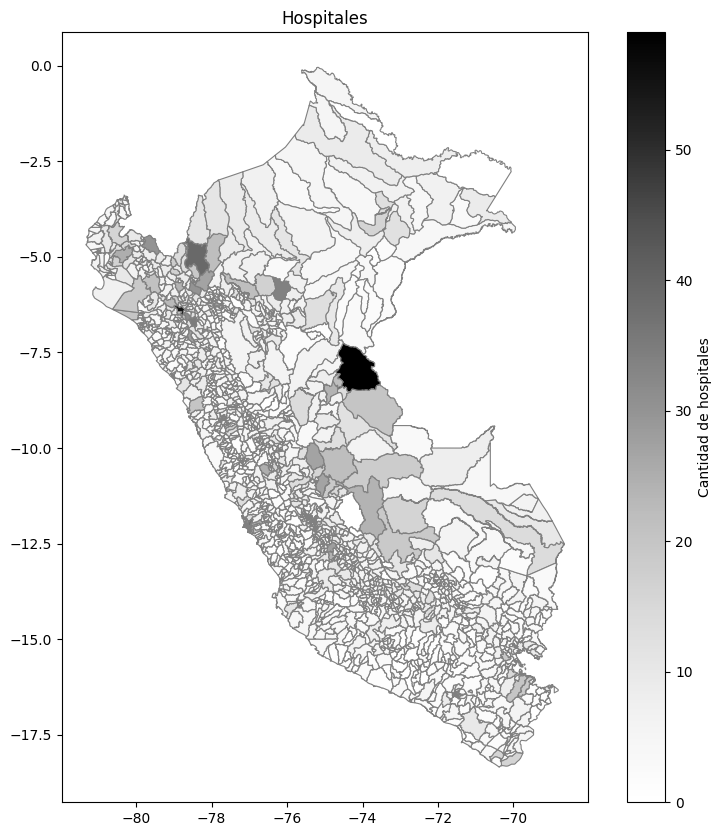

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa
data.plot(ax=ax, column='count',
    cmap='Grays', linewidth=0.8, edgecolor='gray'
)

# Escala
min, max = data['count'].min(), data['count'].max()
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='Grays',
        norm=plt.Normalize(vmin=min, vmax=max)
        ),
    ax=ax)

# title
cbar.set_label("Cantidad de hospitales")
ax.set_title("Hospitales")

fig.savefig("../out/2geopandas/map1.png", dpi=300, bbox_inches='tight')

#### Mapa 2

In [7]:
data[data['count'] == 0].plot(
    ax=ax, color='pink',
)
fig.savefig("../out/2geopandas/map2.png", dpi=300, bbox_inches='tight')

#### Mapa 3

In [8]:
ax.collections[-1].remove() 
cbar.remove()

top10 = data.nlargest(10, 'count')
n10 = int(top10[-1:]['count'])

min, max = data['count'].min(), data['count'].max()
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='Grays',
        norm=plt.Normalize(vmin=min, vmax=n10)
        ),
    ax=ax)

top10.plot(
    ax=ax, column='count',
    cmap='magma',
    legend=True
)

fig.savefig("../out/2geopandas/map3.png", dpi=300, bbox_inches='tight')

C:\Users\cbuen\AppData\Local\Temp\ipykernel_15016\4102588921.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n10 = int(top10[-1:]['count'])


## Task 2

In [9]:
hospDEP = hosp.groupby("Departamento", as_index=False)
hospDEP = hospDEP.agg(hosp=("Red", "count"))
hospDEP.sort_values(by="hosp", ascending=0).reset_index(drop=True)


,Departamento,hosp
0,CAJAMARCA,845
1,LIMA,774
2,JUNIN,493
3,PIURA,442
4,AMAZONAS,417
5,ANCASH,416
6,PUNO,405
7,AYACUCHO,387
8,SAN MARTIN,379
9,APURIMAC,374


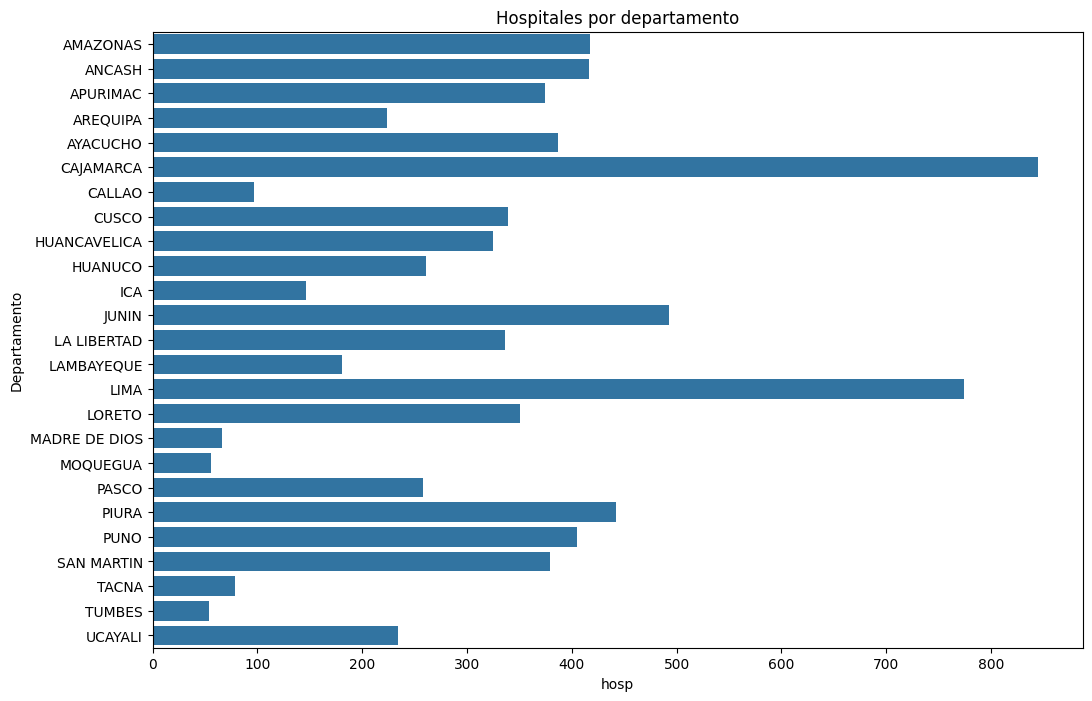

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=hospDEP,
    x="hosp",
    y="Departamento"
)

plt.title("Hospitales por departamento")
plt.show()

plt.savefig("../out/2geopandas/bars.png", dpi=300, bbox_inches='tight')

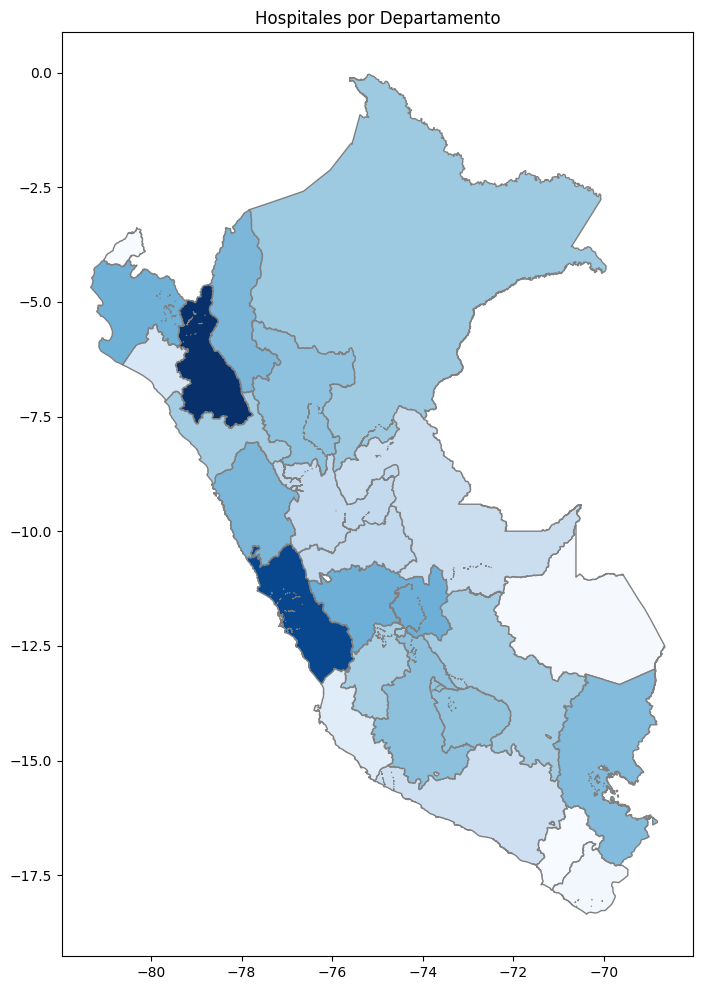

In [11]:
dept_geo = data.dissolve(by='DEPARTAMEN', aggfunc='sum').reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
dept_geo.plot(ax=ax, column='count', cmap='Blues', edgecolor='gray')

ax.set_title('Hospitales por Departamento')
fig.savefig("../out/2geopandas/mapaDEP.png", dpi=300)

plt.show()

#### Task 3

In [12]:
def mapaFol(centros, hosp_32718, idx):
    """
    Dibuja en Folium
    """
    centroid_4326 = gpd.GeoSeries([centros.loc[idx, 'centroid']], crs='EPSG:32718').to_crs('EPSG:4326').iloc[0]
    district_4326 = gpd.GeoSeries([centros.loc[idx, 'geometry']], crs='EPSG:32718').to_crs('EPSG:4326').iloc[0]

    buf_sel = gpd.GeoDataFrame(geometry=[centros.loc[idx, 'buffer_10km']], crs='EPSG:32718')
    hosp_in = gpd.sjoin(hosp_32718, buf_sel, how='inner', predicate='within').drop(columns='index_right').to_crs('EPSG:4326')

    count_val = int(centros.loc[idx, 'Hosp_10km'])
    m = folium.Map(location=[centroid_4326.y, centroid_4326.x], zoom_start=12, tiles='cartodbpositron')

    folium.GeoJson(
        data=district_4326.__geo_interface__,
        name='Distrito',
        style_function=lambda x: {'fillColor':'#777777','color':'#444444','weight':1.5,'fillOpacity':0.15}
    ).add_to(m)

    folium.Circle(
        location=[centroid_4326.y, centroid_4326.x],
        radius=10_000, color='#2b83ba', weight=2, fill=False,
        tooltip=f'Radio 10 km | Hosp: {count_val}'
    ).add_to(m)

    for _, r in hosp_in.iterrows():
        folium.CircleMarker(
            location=[r.geometry.y, r.geometry.x],
            radius=3, color='#d7191c', fill=True, fill_opacity=0.9
        ).add_to(m)

    folium.LayerControl().add_to(m)
    return m

In [13]:
def distrito_concentracion(Departamento="LIMA", concentration=1):
    """
    encuentra distritos de mayor concentracion/aislamiento
    """
    centros = data.loc[data['DEPARTAMEN'] == Departamento].to_crs('EPSG:32718').copy()
    if centros.empty:
        raise ValueError(f"No se encontraron distritos para Departamento='{Departamento}'.")

    centros['centroid']    = centros.geometry.centroid
    centros['buffer_10km'] = centros['centroid'].buffer(10_000)   # círculo puro

    # ================== 2) Hospitales: NORTE=lon, ESTE=lat (4326) → 32718 ==================
    hosp_32718 = gpd.GeoDataFrame(
        hosp.copy(),
        geometry=gpd.points_from_xy(hosp['NORTE'], hosp['ESTE']),
        crs='EPSG:4326'
    ).to_crs('EPSG:32718')

    # ================== 3) Conteo por buffer ==================
    buffers = gpd.GeoDataFrame(geometry=centros['buffer_10km'], crs='EPSG:32718')
    joined  = gpd.sjoin(hosp_32718, buffers, how='left', predicate='within')  # usa 'intersects' si quieres incluir borde
    counts  = joined['index_right'].value_counts().reindex(buffers.index, fill_value=0)
    centros['Hosp_10km'] = counts

    # ================== 4) Selección máx/min ==================
    if concentration == 1:
        idx_obj = centros['Hosp_10km'].idxmax()
    else:
        idx_obj = centros['Hosp_10km'].idxmin()
    conteo = int(centros.loc[idx_obj, 'Hosp_10km'])
    name_col = next((c for c in ['NOMBDIST','NOM_DIST','NOMB_DIST','DISTRITO','NOMBRE'] if c in centros.columns), None)
    nombre = centros.loc[idx_obj, name_col] if name_col else f"idx={idx_obj}"

    # ================== 5) Mapa Folium ==================
    m = mapaFol(centros, hosp_32718, idx_obj)
    out = "../out/2geopandas/"
    m.save(f'{out}folium_{Departamento}_{concentration}.html')

    tag = "máximo" if concentration == 1 else "mínimo"
    print(f"Distrito con {tag} número de hospitales en 10 km en {Departamento}: {nombre} (n={conteo})")

    return idx_obj, nombre, conteo, m


In [14]:
idx, nombre, n, mapa = distrito_concentracion(Departamento="LIMA", concentration=1)
idx, nombre, n, mapa = distrito_concentracion(Departamento="LIMA", concentration=2)
idx, nombre, n, mapa = distrito_concentracion(Departamento="LORETO", concentration=1)
idx, nombre, n, mapa = distrito_concentracion(Departamento="LORETO", concentration=2)

Distrito con máximo número de hospitales en 10 km en LIMA: RIMAC (n=262)
Distrito con mínimo número de hospitales en 10 km en LIMA: SAN PEDRO DE PILAS (n=0)
Distrito con máximo número de hospitales en 10 km en LORETO: BELEN (n=16)
Distrito con mínimo número de hospitales en 10 km en LORETO: PADRE MARQUEZ (n=0)


## 3 interactive Mapping with Folium

### task 1

In [ ]:
import folium
import geopandas as gpd
from folium.plugins import MarkerCluster

# datos para coropletas
df_dists = data.copy()
df_dists["UBIGEO"] = df_dists["UBIGEO"].astype(str)
df_dists.geometry = df_dists.geometry.simplify(0.1, preserve_topology=True) #simplificar poligonos
gj_dists = df_dists.to_json()

# puntos de hospitales
pts_hosp = gpd.GeoDataFrame(
    hosp.copy(),
    geometry=gpd.points_from_xy(hosp["NORTE"], hosp["ESTE"]),
    crs="EPSG:32718"
).to_crs(epsg=4326)

# mapa base
mapa_pe = folium.Map(location=[-9, -75], zoom_start=5, tiles="CartoDB Voyager")

# coropletas
folium.Choropleth(
    geo_data=gj_dists,
    name="Hospitales por distrito",
    data=df_dists,
    columns=["UBIGEO", "count"],
    key_on="feature.properties.UBIGEO",
    fill_color="PuBu",
    fill_opacity=0.85,
    line_opacity=0.5,
    nan_fill_color="white",
    legend_name="Número de hospitales"
).add_to(mapa_pe)

# límites y tooltip
folium.GeoJson(
    data=gj_dists,
    name="Distritos",
    tooltip=folium.GeoJsonTooltip(
        fields=["UBIGEO", "count"],
        aliases=["UBIGEO:", "Hospitales:"],
        localize=True
    ),
    style_function=lambda _: {"fillOpacity": 0, "color": "#374151", "weight": 0.6}
).add_to(mapa_pe)

# marcadores agrupados
grp_hosp = MarkerCluster(name="Hospitales").add_to(mapa_pe)
for _, r in pts_hosp.iterrows():
    info = (
        f"{r.get('Nombre del establecimiento','Establecimiento')}<br>"
        f"Departamento: {r.get('Departamento','')}<br>"
        f"UBIGEO: {r.get('UBIGEO','')}"
    )
    folium.Marker(
        location=[r.geometry.y, r.geometry.x],
        popup=info,
        icon=folium.Icon(color="cadetblue", icon="hospital-o", prefix="fa")
    ).add_to(grp_hosp)

folium.LayerControl(collapsed=True).add_to(mapa_pe)
mapa_pe.save("../out/3folium/choropleth.html")



#### Task 2

In [ ]:
def mapaFol(centros, hosp_32718, idx, m=None, circle_color="#2b83ba", layer_name="Capa"):
    """
    Dibuja en Folium: distrito, círculo 10 km y hospitales dentro para el índice idx.
    Cambios mínimos:
      - círculo con fill (sombreado) usando circle_color
      - hospitales en puntos negros, más pequeños y semitransparentes
      - tooltip y popup con nombre del distrito y conteo
    """
    # Geometrías a 4326 para Leaflet
    centroid_4326 = gpd.GeoSeries([centros.loc[idx, 'centroid']], crs='EPSG:32718').to_crs('EPSG:4326').iloc[0]
    district_4326 = gpd.GeoSeries([centros.loc[idx, 'geometry']],  crs='EPSG:32718').to_crs('EPSG:4326').iloc[0]

    # Hospitales dentro del buffer seleccionado
    buf_sel  = gpd.GeoDataFrame(geometry=[centros.loc[idx, 'buffer_10km']], crs='EPSG:32718')
    hosp_in  = gpd.sjoin(hosp_32718, buf_sel, how='inner', predicate='within').drop(columns='index_right').to_crs('EPSG:4326')

    # Nombre y conteo para tooltip/popup
    name_col = next((c for c in ['NOMBDIST','NOM_DIST','NOMB_DIST','DISTRITO','NOMBRE'] if c in centros.columns), None)
    nombre   = centros.loc[idx, name_col] if name_col else f"idx={idx}"
    count_val = int(centros.loc[idx, 'Hosp_10km'])
    info_txt = f"{nombre} — {count_val} hospitales en 10 km"

    # Mapa base (si no se pasó uno)
    if m is None:
        m = folium.Map(location=[centroid_4326.y, centroid_4326.x], zoom_start=12, tiles='cartodbpositron')

    # Capa separada para este caso
    fg = folium.FeatureGroup(name=layer_name, show=True)

    # Distrito
    folium.GeoJson(
        data=district_4326.__geo_interface__,
        name='Distrito',
        style_function=lambda x: {'fillColor':'#777777','color':'#444444','weight':1.5,'fillOpacity':0.15}
    ).add_to(fg)

    # Círculo de 10 km (sombreado con color)
    folium.Circle(
        location=[centroid_4326.y, centroid_4326.x],
        radius=10_000,
        color=circle_color, weight=2,
        fill=True, fill_color=circle_color, fill_opacity=0.25,   # << sombreado
        tooltip=info_txt, popup=info_txt                        # << tooltip + popup
    ).add_to(fg)

    # Hospitales dentro: puntos negros, pequeños, semitransparentes
    for _, r in hosp_in.iterrows():
        folium.CircleMarker(
            location=[r.geometry.y, r.geometry.x],
            radius=2,                     # << más pequeño
            color='#000000', weight=0.5,  # borde negro fino
            fill=True, fill_color='#000000', fill_opacity=0.55   # << semitransparente
        ).add_to(fg)

    fg.add_to(m)
    return m


def distrito_concentracion_data(Departamento="LIMA", concentration=1):
    """
    Calcula círculos de 10 km desde centroides por distrito del 'Departamento',
    cuenta hospitales dentro y selecciona:
      - concentration=1 -> distrito con MÁX hospitales
      - concentration=2 -> distrito con MÍN hospitales
    Devuelve: centros (gdf 32718), hosp_32718 (gdf 32718), idx_obj, nombre, conteo
    """
    if concentration not in (1, 2):
        raise ValueError("concentration debe ser 1 (máximo) o 2 (mínimo).")

    # Distritos del depto en 32718
    centros = data.loc[data['DEPARTAMEN'] == Departamento].to_crs('EPSG:32718').copy()
    if centros.empty:
        raise ValueError(f"No se encontraron distritos para Departamento='{Departamento}'.")

    centros['centroid']    = centros.geometry.centroid
    centros['buffer_10km'] = centros['centroid'].buffer(10_000)

    # Hospitales: NORTE=lon, ESTE=lat en 4326 → 32718
    hosp_32718 = gpd.GeoDataFrame(
        hosp.copy(),
        geometry=gpd.points_from_xy(hosp['NORTE'], hosp['ESTE']),
        crs='EPSG:4326'
    ).to_crs('EPSG:32718')

    # Conteo
    buffers = gpd.GeoDataFrame(geometry=centros['buffer_10km'], crs='EPSG:32718')
    joined  = gpd.sjoin(hosp_32718, buffers, how='left', predicate='within')
    counts  = joined['index_right'].value_counts().reindex(buffers.index, fill_value=0)
    centros['Hosp_10km'] = counts

    # Selección máx/min
    idx_obj = centros['Hosp_10km'].idxmax() if concentration == 1 else centros['Hosp_10km'].idxmin()
    conteo  = int(centros.loc[idx_obj, 'Hosp_10km'])
    name_col = next((c for c in ['NOMBDIST','NOM_DIST','NOMB_DIST','DISTRITO','NOMBRE'] if c in centros.columns), None)
    nombre = centros.loc[idx_obj, name_col] if name_col else f"idx={idx_obj}"

    return centros, hosp_32718, idx_obj, nombre, conteo





In [30]:
# ======================= Mapa Único con 4 casos =======================
# Verde para concentración=1 (máximo), Rojo para concentración=2 (mínimo)
color_por_conc = {1: "#1a9850", 2: "#d73027"}

m_unico = folium.Map(location=[-9.19, -75.02], zoom_start=5.5, tiles='cartodbpositron')

casos = [("LIMA", 1), ("LIMA", 2), ("LORETO", 1), ("LORETO", 2)]
for depto, conc in casos:
    centros, hosp_32718, idx, nombre, conteo = distrito_concentracion_data(Departamento=depto, concentration=conc)
    layer_name = f"{depto} — {'MAX' if conc==1 else 'MIN'} | {nombre} (n={conteo})"
    m_unico = mapaFol(
        centros, hosp_32718, idx,
        m=m_unico,
        circle_color=color_por_conc[conc],
        layer_name=layer_name
    )

folium.LayerControl().add_to(m_unico)

out = "../out/3folium/"
m_unico.save(f"{out}folium_completo.html")